In [409]:
import os, os.path as op, pandas as pd, numpy as np
from glob import glob
import seaborn as sns
u = lambda x: list(set(x))
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
sns.set(font="Helvetica")
flatten = lambda t: [item for sublist in t for item in sublist]
def tryconvert(value, default=int, if_error=np.nan):
    try:
        return default(value)
    except (ValueError, TypeError):
        return if_error

def tryconvertList(lst, default=int, if_error=np.nan):
    vals = []
    for val in lst:
        try:
            vals.append(default(val))
        except:
            vals.append(if_error)
    return vals
    
def handleKeyError(value, if_error):
    try:
        return value
    except KeyError:
        return if_error
    
import statsmodels.stats.api as sms



In [4]:
tps = ['tp-1', 'tp0']

In [5]:
logs = {tps[i]:glob(f"data/{tps[i]}/*.log") for i in range(len(tps))}

In [6]:
tasks = u([e.split("-")[-1].split(".")[0] for e in glob("data/tp-1/*.log")])
tasks = [t for t in tasks if "FinTapp" not in t]
participants = u([op.split(e)[-1].split('-')[0] for e in glob("data/tp-1/*.log")])

In [455]:
tasks = [t for t in tasks if 'LDT' in t]
dfs = {}
dGroup = pd.DataFrame({k:[] for k in ['subject','blockType','tp','percCorrect','nStim','nCorrect','nIncorrect']})
dGroupAll = pd.DataFrame({k:[] for k in ['blockType', 'tp', 'task']})
dPartAll = {}
for task in tasks:
    dGroup = pd.DataFrame({k:[] for k in ['subject','blockType','tp','percCorrect','nStim','nCorrect','nIncorrect']})
    #task = "LDTVisL1"
    for p in participants:
        dPartAll[p] = pd.DataFrame({k:[] for k in ['subject','blockType','tp','percCorrect','nStim','nCorrect','nIncorrect']})
        dfs[p] = {}
        fls = []
        for tp in tps:
            fls.append([f for f in logs[tp] if p in f])
        fls = flatten(fls)
        
        if len([pd.read_csv(f, skiprows=3, sep = "\t") for f in fls if task in f]) > 1:
            dfs[p][task] = pd.concat([pd.read_csv(f, skiprows=3, sep = "\t") for f in fls if task in f])
            dfs[p][task].columns = [c.lower() for c in list(dfs[p][task].columns)]
            dfs[p][task] = dfs[p][task][(dfs[p][task]["subject"].str.contains(p)) &
                                        (~dfs[p][task]["subject"].str.contains("subject")) ]
            dfs[p][task]["tp"] = dfs[p][task]["subject"].apply(lambda x: x.split("_")[-1]
                                                               if "tp" in x.split("_")[-1]
                                                               else "tp-1")
            dfs[p][task]["subject"] = dfs[p][task]["subject"].apply(lambda x: x.split("_")[0])
            dfs[p][task] = dfs[p][task].reset_index(drop=True)
            dfs[p][task] = dfs[p][task][((dfs[p][task]["event type"] == "Response") &
                                         (dfs[p][task]["code"] != "3")) |
                                        (dfs[p][task]["code"].str.contains(task))].reset_index(drop=True)
            dfs[p][task] = pd.DataFrame(data={"word":[dfs[p][task].code[i]
                                                      for i in np.array(dfs[p][task][dfs[p][task].code.str.contains(task)].index)],
         "participantAnswer":[tryconvert(dfs[p][task].code[i+1]) if i+1 in np.array(dfs[p][task].index) else np.nan
                              for i in np.array(dfs[p][task][dfs[p][task].code.str.contains(task)].index)],
                                     "tp":np.array(dfs[p][task][dfs[p][task].code.str.contains(task)].tp),
                                    "subject":[p]*len(np.array(dfs[p][task][dfs[p][task].code.str.contains(task)].tp))})

            dfs[p][task]["corrAns"] = dfs[p][task]["word"].apply(lambda x: x.split("-")[-1]).map({"w":1,"p":2,"t":1,"n":2,"y":1})
            dfs[p][task]["blockType"] = dfs[p][task]["word"].apply(lambda x:
                                                           "experimental"
                                                           if (x.split("-")[-1] == "w" or
                                                               x.split("-")[-1] == "p")
                                      else "control" )
            dfs[p][task]["stimType"] = dfs[p][task]["word"].apply(lambda x: "word" if x.split("-")[-1] == "w" else
                                         ("pseudoword" if x.split("-")[-1] == "p" else
                                          ("hash" if x.split("-")[-1] == "t" or x.split("-")[-1] == "y" else "no hash")))

            dfs[p][task]["participantCorrect"] = (dfs[p][task]["corrAns"] == dfs[p][task]["participantAnswer"]).astype(int)*100
            _stat = (dfs[p][task].groupby(['subject','blockType','tp']).agg(percCorrect=('participantCorrect','mean'),
                                                           nStim = ("participantCorrect",'size')).reset_index()
                .assign(nCorrect = lambda x: x["nStim"]*x["percCorrect"]/100,
                nIncorrect = lambda x: x["nStim"]-x["nCorrect"]))
            
           
            
            
            dGroup = pd.concat([dGroup,_stat])
        dGroup = dGroup.sort_values(["subject", 'tp','blockType'],ascending=[True,True,False]).reset_index(drop=True)

        dGroup["task"] = task
        
        dGroupAll = pd.concat([dGroupAll, dGroup])
        
for p in dGroupAll.subject.unique():
    _d = dGroupAll[dGroupAll.subject == p]
    g = sns.FacetGrid(_d, col="task", height=4, aspect=.5,sharex=False, sharey=True,
                 col_order = ["LDTVisL1","LDTVisBra","LDTTactBra"])
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(f'Lexical decision tasks - participant {p}')
    g.map(sns.barplot,'tp', 'percCorrect','blockType',
         hue_order = ['experimental','control'],palette = 'colorblind',alpha = .8,errcolor="black")
    g.set_axis_labels("", "Percentage of correct answers")
    axes = g.axes.flatten()
    axes[0].set_title("Visual L1")
    axes[1].set_title("Visual Braille")
    axes[2].set_title("Tactile Braille")
    g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$'])
    for (i,j,k), data in g.facet_data():
        if data.empty:
            ax = g.facet_axis(i, j)
            ax.set_axis_off()

    # plot the legend
    #plt.legend(, loc='upper center')
    plt.legend(borderaxespad=0.,ncol=2,loc='best', bbox_to_anchor=(0, -.15, 0, 0),frameon=False)
    plt.yticks(range(0,101,10))
    #plt.show()

    plt.savefig(f"LDT_{p}.png",dpi=300)
    plt.close()

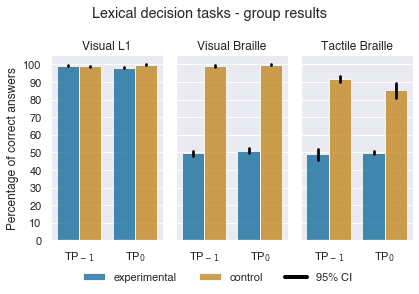

In [452]:
g = sns.FacetGrid(dGroupAll, col="task", height=4, aspect=.5,sharex=False, sharey=True,
                 col_order = ["LDTVisL1","LDTVisBra","LDTTactBra"])
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Lexical decision tasks - group results')
g.map(sns.barplot,'tp', 'percCorrect','blockType',
     hue_order = ['experimental','control'],palette = 'colorblind',alpha = .8,errcolor="black")
g.set_axis_labels("", "Percentage of correct answers")
axes = g.axes.flatten()
axes[0].set_title("Visual L1")
axes[1].set_title("Visual Braille")
axes[2].set_title("Tactile Braille")
g.set_xticklabels([r'TP$_-$$_1$',r'TP$_0$'])
for (i,j,k), data in g.facet_data():
    if data.empty:
        ax = g.facet_axis(i, j)
        ax.set_axis_off()


handles, labels = plt.gca().get_legend_handles_labels()
from matplotlib.lines import Line2D
# manually define a new patch 
patch = Line2D([0], [0], color='black', lw=4,label="95% CI")
# handles is a list, so append manual patch
handles.append(patch) 

# plot the legend
#plt.legend(, loc='upper center')
plt.legend(handles=handles,borderaxespad=0.,ncol=3,loc='best', bbox_to_anchor=(0.5, -.15, 0, 0),frameon=False)
plt.yticks(range(0,101,10))
#plt.show()

plt.savefig("LDT_group.png",dpi=300)